## Summary of the notebook

Deep Ensemble model trained in the notebook : GBP_CHD_deep_ensemble_training.ipynb 

**train configuration**: <br> 
eager execution = disabled

**process** 
1. Load the ensemble model from the trained model path in a list (say list name = model)
2. Pass the model_function() [the same function in which the model architecture was defined], the number of estimators, and the trained model [the list in which we recently loaded the trained models] into the DeepEnsembleRegressor constructor
3. The DeepEnsembleRegressor will return a model, say stochastic_model 
4. Using stochastic_model, we can access predict_output() of DeepEnsembleRegressor
5. This function will return a prediction mean and prediction std 
6. Plot these prediction mean and prediction std against gt to check the stochastic behaviour of the model 
7. The code for GBP explanation calculation is adapted to handle the disabled eager execution 
8. For the number of ensemble components, run a for loop. Every time the explanation method is called, it returns the sample explanation (1, 8) and the ensemble component output (1, 1)
9. Using the sample explanation (of shape (1,8)) for say 2 estimators, compute the mean and std explanation (each of shape (1, 8)).
10. The ensemble component output for say 2 estimators can be used to compute the mean prediction and std dev prediction which are then used to complete the title of the combination epxlanation.

## Mount the drive

In [1]:
# mount the drive

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Setting the correct path

In [2]:
import os

project_path = '/content/drive/MyDrive/MasterThesis'
task_name = 'CaliforniaHousingDatasetTests'
exp_name = 'GBP_explanation'
uncert_name = 'deep_ensemble'

%cd /content/drive/MyDrive/MasterThesis/ 

print(os.getcwd())
path = project_path + '/' + task_name + '/' + exp_name + '/' + uncert_name + '/' # 'CaliforniaHousingDatasetTests/GBP_explanation/flipout/'
print(path)

/content/drive/MyDrive/MasterThesis
/content/drive/MyDrive/MasterThesis
/content/drive/MyDrive/MasterThesis/CaliforniaHousingDatasetTests/GBP_explanation/deep_ensemble/


## Removing previous plots and explanations

In [3]:
import glob, os, os.path
output_plot_path = path+'output_plots/'
filelist_pdf = glob.glob(os.path.join(output_plot_path, '*.pdf'))
filelist_png = glob.glob(os.path.join(output_plot_path, '*.png'))

# removing pdf explanatiosn 
for f in filelist_pdf:
    print(f'removing file {f}')
    os.remove(f)

for f in filelist_png:
    print(f'removing file {f}')
    os.remove(f)

removing file /content/drive/MyDrive/MasterThesis/CaliforniaHousingDatasetTests/GBP_explanation/deep_ensemble/output_plots/deep_ensemble_vs_prediction.pdf
removing file /content/drive/MyDrive/MasterThesis/CaliforniaHousingDatasetTests/GBP_explanation/deep_ensemble/output_plots/deep_ensemble_vs_prediction.png


## Imports

In [4]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import tensorflow as tf

import os
import random 
import math

import seaborn as sns 

from keras.layers import *
from keras.models import Model, Sequential
import keras.backend as K

tf.compat.v1.disable_eager_execution()
print(tf.__version__)
print(f'Eager execution enabled : {tf.executing_eagerly()}')

import sys
sys.path.insert(0,'/content/drive/My Drive/MasterThesis/src/')

from utils import *

2.8.2
Eager execution enabled : False


## regression_nll_loss

In [5]:
import tensorflow as tf 

def regression_gaussian_nll_loss(variance_tensor, epsilon=1e-8, variance_logits=False):
    """
        Gaussian negative log-likelihood for regression, with variance estimated by the model.
        This function returns a keras regression loss, given a symbolic tensor for the sigma square output of the model.
        The training model should return the mean, while the testing/prediction model should return the mean and variance.
    """
    def nll(y_true, y_pred):
        #if variance_logits:
        #    variance_tensor = K.exp(variance_tensor)

        return 0.5 * tf.math.reduce_mean(tf.math.log(variance_tensor + epsilon) + tf.math.square(y_true - y_pred) / (variance_tensor + epsilon))

    return nll

## Load data

In [6]:
train_data, train_labels, val_data, val_labels, test_data, test_labels, feature_names = load_california_housing_data()
#print(train_labels[20])
#print(val_labels[30])
#print(test_labels[40])

['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'median_house_value']
Training data shape 
 (12750, 8)
Training labels shape 
 (12750, 1)
Validation data shape 
  (4250, 8)
Validation labels shape 
  (4250, 1)
Test data shape 
  (3000, 8)
Test labels shape 
  (3000, 1)


## Class definition

### DeepEnsemble

In [7]:
import keras
import numpy as np
import keras

import os
import yaml

from pydoc import locate
 
METADATA_FILENAME = "metadata.yml"

class DeepEnsemble:
    def __init__(self, model_fn=None, num_estimators=None, models=None, needs_test_estimators=False):
        self.needs_test_estimators = needs_test_estimators
        self.model_fn = model_fn
        self.num_estimators = num_estimators
        self.models = models

        if models is None:
            assert model_fn is not None and num_estimators is not None
            assert num_estimators > 0
            
            self.num_estimators = num_estimators
            self.train_estimators = [None] * num_estimators 
            self.test_estimators = [None] * num_estimators

            print('train_estimators ', self.train_estimators)
            print('test_estimators ', self.test_estimators)
            print('num_estimators ', self.num_estimators)
            

            for i in range(self.num_estimators):
                if self.needs_test_estimators:
                    estimators = model_fn()

                    if type(estimators) is not tuple:
                        raise ValueError("model_fn should return a tuple")

                    if len(estimators) != 2:
                        raise ValueError("model_fn returned a tuple of unexpected size ({} vs 2)".format(len(estimators)))

                    train_est, test_est = estimators
                    self.train_estimators[i] = train_est
                    self.test_estimators[i] = test_est
                    
                else:
                    est = model_fn()
                    print('len of est ', len(est))
                    self.train_estimators[i] = est[0]
                    self.test_estimators[i] = est[1]
                    #print(f'train_estimators[{i}] : {est}')
                    #print(f'test_estimators[{i}] : {est}')

        else:
            if (model_fn is None and num_estimators is None):   # assert raises error with integer value for num_estimators   # https://stackoverflow.com/questions/46850472/assert-using-python-how-do-i-check-if-the-input-is-integer-or-not
                raise AssertionError('assign values to model_fn and num_estimators')

            self.train_estimators = models
            self.test_estimators = models
            self.num_estimators = len(models)


    def save(self, folder, filename_pattern="model-ensemble-{}.hdf5"):
        """
            Save a Deep Ensemble into a folder, using individual HDF5 files for each ensemble member.
            This allows for easily loading individual ensembles. Metadata is saved to allow loading of the whole ensemble.
        """

        if not os.path.exists(folder):
            os.makedirs(folder)

        model_metadata = {}

        for i in range(self.num_estimators):
            filename = os.path.join(folder, filename_pattern.format(i))
            self.test_estimators[i].save(filename)

            print("Saved estimator {} to {}".format(i, filename))

            model_metadata[i] = filename_pattern.format(i)

        metadata = {"models": model_metadata, "class": self.__module__}

        with open(os.path.join(folder, METADATA_FILENAME), 'w') as outfile:
            yaml.dump(metadata, outfile)
            

    @staticmethod
    def load(folder):
        """
            Load a Deep Ensemble model from a folder containing individual HDF5 files.
        """
        metadata = {}

        with open(os.path.join(folder, METADATA_FILENAME)) as infile:
            metadata = yaml.full_load(infile)

        models = []

        for _, filename in metadata["models"].items():
            models.append(keras.models.load_model(os.path.join(folder, filename)))

        clazz = locate(metadata["class"])

        return clazz(models=models)  

### DeepEnsembleRegressor

In [8]:
class DeepEnsembleRegressor(DeepEnsemble):
    """
        Implementation of a Deep Ensemble for regression.
        Uses two models, one for training and another for inference/testing. The user has to provide a model function that returns
        the train and test models, and use the provided deep_ensemble_nll_loss for training.
    """
    def __init__(self, model_fn=None, num_estimators=None, models=None):
        """
            Builds a Deep Ensemble given a function to make model instances, and the number of estimators.
            For training it uses a model that only outputs the mean, while the loss uses both the mean and variance produced by the model.
            For testing, a model that shares weights with the training model is used, but the testing model outputs both mean and variance. The final
            prediction is made with a mixture of gaussians, where each gaussian is one trained model instance.
        """
        super().__init__(model_fn=model_fn, num_estimators=num_estimators, models=models,
                         needs_test_estimators=True)
        
    def summary(self):
        print('training model summary ')
        print(self.model_fn()[0].summary())
        print('xxxxxxxxxxxxxxx')
        print('prediction model summary ')
        print(self.model_fn()[1].summary())
        

    def fit(self, X, y, epochs=10, batch_size=32, **kwargs):
        """
            Fits the Deep Ensemble, each estimator is fit independently on the same data.
        """

        for i in range(self.num_estimators):
            history = self.train_estimators[i].fit(X, y, epochs=epochs, batch_size=batch_size, **kwargs)

            # plotting the training and validation curves
            plt.plot(history.history['loss'], label='train loss')
            plt.plot(history.history['val_loss'], label='val loss')
            plt.legend()
            plt.grid()
            plt.xlabel('epochs')
            plt.ylabel('loss')
            plt.title('loss curves')
            plt.show()

            plt.plot(history.history['mae'], label='train mae')
            plt.plot(history.history['val_mae'], label='val mae')
            plt.legend()
            plt.grid()
            plt.xlabel('epochs')
            plt.ylabel('mae')
            plt.title('mae curves')
            plt.show()
            
    
    def fit_generator(self, generator, epochs=10, **kwargs):
        """
            Fits the Deep Ensemble, each estimator is fit independently on the same data.
        """

        for i in range(self.num_estimators):
            self.train_estimators[i].fit_generator(generator, epochs=epochs, **kwargs)
            

    def predict_output(self, X, batch_size=32, output_scaler=None, num_ensembles=None, disentangle_uncertainty=False, **kwargs):
        """
            Makes a prediction. Predictions from each estimator are used to build a gaussian mixture and its mean and standard deviation returned.
        """
        
        means = []
        variances = []

        if num_ensembles is None:
            estimators = self.test_estimators
        else:
            estimators = self.test_estimators[:num_ensembles]

        if "verbose" not in kwargs:
            kwargs["verbose"] = 0

        for estimator in estimators:
            mean, var  = estimator.predict(X, batch_size=batch_size, **kwargs)

            if output_scaler is not None:
                mean = output_scaler.inverse_transform(mean)

                # This should work but not sure if its 100% correct
                # Its not clear how to do inverse scaling of the variance
                sqrt_var = np.sqrt(var)
                var = output_scaler.inverse_transform(sqrt_var)
                var = np.square(var)

            means.append(mean)
            variances.append(var)

        means = np.array(means)
        variances = np.array(variances)
        
        mixture_mean = np.mean(means, axis=0)
        #print('mixture_mean shape \n', mixture_mean.shape)
        #print('mixture_mean \n', mixture_mean)
        mixture_var  = np.mean(variances + np.square(means), axis=0) - np.square(mixture_mean)
        mixture_var[mixture_var < 0.0] = 0.0
        #print('mixture_var shape \n', mixture_var.shape)
        #print('mixture_var \n', mixture_var)
                
        if disentangle_uncertainty:
            epi_var = np.var(means, axis=0)
            ale_var = np.mean(variances, axis=0)

            return mixture_mean, np.sqrt(ale_var), np.sqrt(epi_var)
        print('mixture_mean is ', mixture_mean)
        print('mixture_var is ', mixture_var) 
        return mixture_mean, np.sqrt(mixture_var)

    def predict_generator(self, generator, steps=None, num_ensembles=None, **kwargs):
        """
            Makes a prediction. Predictions from each estimator are used to build a gaussian mixture and its mean and standard deviation returned.
        """
        
        means = []
        variances = []

        if num_ensembles is None:
            estimators = self.test_estimators
        else:
            estimators = self.test_estimators[:num_ensembles]

        for estimator in estimators:
            mean, var  = estimator.predict_generator(generator, steps=steps, **kwargs)
            means.append(mean)
            variances.append(var)

        means = np.array(means)
        variances = np.array(variances)
        
        mixture_mean = np.mean(means, axis=0)
        mixture_var  = np.mean(variances + np.square(means), axis=0) - np.square(mixture_mean)
        mixture_var[mixture_var < 0.0] = 0.0
                
        return mixture_mean, np.sqrt(mixture_var)

## Load the saved models

In [9]:
# slightly different procedure to load the ensemble model from yaml file 

import os


#dir_name = '/content/drive/MyDrive/MasterThesis/CaliforniaHousingDatasetTests/GBP_explanation/deep_ensemble/'
#test = os.listdir(dir_name)

#for item in test:
#    if '.h5' in item:
#        dir = dir_name+item
#        with open(dir+'/model_as_json.json', 'r') as json_file:
#            json_savedModel=json_file.read()
#        model = tf.keras.models.model_from_json(json_savedModel)

#model.summary()

# reference : https://towardsdatascience.com/saving-and-loading-keras-model-42195b92f57a

model = [] 
num_estimators = 0 

model = [] 
num_estimators = 0 
for item in os.listdir(path):
    if '.h5' in item:
        print(path+item)
        for i in os.listdir(path+item):
            print(i)
            if '.hdf5' in i:
                model_variable = tf.keras.models.load_model(path+item+'/'+i)
                model.append(model_variable)
                


print('total number of ensemble components : ', len(model))

/content/drive/MyDrive/MasterThesis/CaliforniaHousingDatasetTests/GBP_explanation/deep_ensemble/ensemble_model_epochs_100_num_estimators_10.h5
model-ensemble-0.hdf5
model-ensemble-1.hdf5
model-ensemble-2.hdf5
model-ensemble-3.hdf5
model-ensemble-4.hdf5
model-ensemble-5.hdf5
model-ensemble-6.hdf5
model-ensemble-7.hdf5
model-ensemble-8.hdf5
model-ensemble-9.hdf5
metadata.yml
total number of ensemble components :  10


## Define the ensemble model [check if this is the same model as the one trained in the other notebook]

In [10]:
#obtained from hyperparameter optimization
def model_function():
    inp = Input(shape=(8,))
    x = Dense(8, activation='relu')(inp)
    x = Dense(8, activation='relu')(x)
    x = Dense(8, activation='relu')(x)
    mean = Dense(1, activation='linear')(x)
    var = Dense(1, activation='softplus')(x)

    train_model = Model(inp, mean)
    pred_model = Model(inp, [mean, var])
    #train_model.compile(loss='mse', optimizer='sgd', metrics=['mae'])   

    
    train_model.compile(loss=regression_gaussian_nll_loss(var), optimizer='adam', metrics=['mae'])

    return train_model, pred_model 
        

## Prediction on test set

In [11]:
'''
# Analysis of the input
num_of_inputs_to_be_explained = 1

start_index = np.random.randint(0, test_data.shape[0])
print('start_index : ', start_index)

test_input = test_data[start_index:start_index+num_of_inputs_to_be_explained]
print('test_input shape : ', test_input.shape)

test_label = test_data[start_index:start_index+num_of_inputs_to_be_explained]
print('test_label : ', test_data[start_index:start_index+num_of_inputs_to_be_explained])

test_input_adj = np.expand_dims(test_input, axis=-1)
print('test_input_adj shape :', test_input_adj.shape)
'''

# MODEL PREDICTION AND PLOTTING 
stochastic_model = DeepEnsembleRegressor(model_fn=model_function, num_estimators=len(model), models=model)
pred_mean, pred_std = stochastic_model.predict_output(test_data, num_ensembles=len(model)) #we calculate mix_Var but return sqrt of it hence catch it in pred_std

print('test_labels \n ', test_labels)
print('pred_mean \n ', pred_mean)

mse_test_set = np.mean((test_labels - pred_mean)**2, axis=1)

print('mse test set ', mse_test_set)
print('mse test set shape ', mse_test_set.shape)

# ascending order (last 5 values will be the worst predictions)
sorted_mse_test_set = sorted(mse_test_set)

print('sorted_mse_test_set \n ', sorted_mse_test_set)
print('max sorted_mse_test_set \n ', np.max(sorted_mse_test_set))
print('min sorted_mse_test_set \n ', np.min(sorted_mse_test_set))

sorted_mse_test_set_index = [list(mse_test_set).index(i) for i in sorted_mse_test_set]
print('sorted_mse_test_set_index \n ', sorted_mse_test_set_index)


difficulty = 'difficult'
number_of_most_extreme_inputs_to_be_analysed = 30

if difficulty == 'difficult':
    index_of_most_extreme_inputs_to_predict = sorted_mse_test_set_index[-number_of_most_extreme_inputs_to_be_analysed:]
    print('sorted (ascending order of difficulty) index of most difficult inputs to predict : \n', index_of_most_extreme_inputs_to_predict)

elif difficulty == 'easy':
    index_of_most_extreme_inputs_to_predict = sorted_mse_test_set_index[:number_of_most_extreme_inputs_to_be_analysed]
    print('sorted (ascending order of difficulty) index of most easy inputs to predict : \n', index_of_most_extreme_inputs_to_predict)


/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


mixture_mean is  [[0.47852015]
 [0.41407552]
 [0.4454878 ]
 ...
 [0.26707926]
 [0.37321028]
 [0.5677105 ]]
mixture_var is  [[0.27034765]
 [0.2610216 ]
 [0.26620656]
 ...
 [0.28855443]
 [0.2655515 ]
 [0.28991327]]
test_labels 
  [[0.67476298]
 [0.32251241]
 [0.51937064]
 ...
 [0.08272234]
 [0.2931931 ]
 [1.        ]]
pred_mean 
  [[0.47852015]
 [0.41407552]
 [0.4454878 ]
 ...
 [0.26707926]
 [0.37321028]
 [0.5677105 ]]
mse test set  [0.03851125 0.0083838  0.00545867 ... 0.03398748 0.00640275 0.1868742 ]
mse test set shape  (3000,)
sorted_mse_test_set 
  [1.3066274705831566e-08, 1.4765692691440505e-08, 5.892483778272858e-08, 1.685415990319508e-07, 2.5019833174819816e-07, 2.6159089856050905e-07, 2.6832444891919994e-07, 5.350665793636663e-07, 6.079361932738115e-07, 9.85546062113277e-07, 1.0431807472988372e-06, 2.053757842260134e-06, 2.068989105660212e-06, 2.258985253379065e-06, 2.5563886147861306e-06, 2.557047119106834e-06, 2.5766929145333853e-06, 3.622406771407252e-06, 4.210583675125656e-0

### Identifying extreme inputs

In [12]:
list_of_gt = [] 

print('input features :\n', feature_names)

for i in index_of_most_extreme_inputs_to_predict:
    print(f'features for input # {i}: \n', test_data[i, :])
    print(f'output gt for input # {i} : \n', test_labels[i])
    list_of_gt.append(test_labels[i])

input features :
 ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'median_house_value']
features for input # 2647: 
 [0.58617131 0.15598291 0.52941176 0.16761924 0.27321396 0.19346186
 0.29403409 0.19494214]
output gt for input # 2647 : 
 [0.96502416]
features for input # 2738: 
 [0.59133127 0.14957265 0.45098039 0.10153068 0.14565258 0.08968986
 0.12926136 0.36020882]
output gt for input # 2738 : 
 [1.]
features for input # 2636: 
 [0.33642931 0.54166667 0.74509804 0.00128104 0.00110762 0.00142498
 0.00142045 0.08744707]
output gt for input # 2636 : 
 [0.89528608]
features for input # 702: 
 [0.24458204 0.4284188  0.23529412 0.09932992 0.07587225 0.08566639
 0.07325487 0.44562144]
output gt for input # 702 : 
 [1.]
features for input # 283: 
 [0.21362229 0.51709402 0.58823529 0.09295756 0.09008676 0.09497066
 0.09719968 0.30703025]
output gt for input # 283 : 
 [1.]
features for input # 2757: 
 [0.59752322 0

## GT vs prediction visualization for selected points

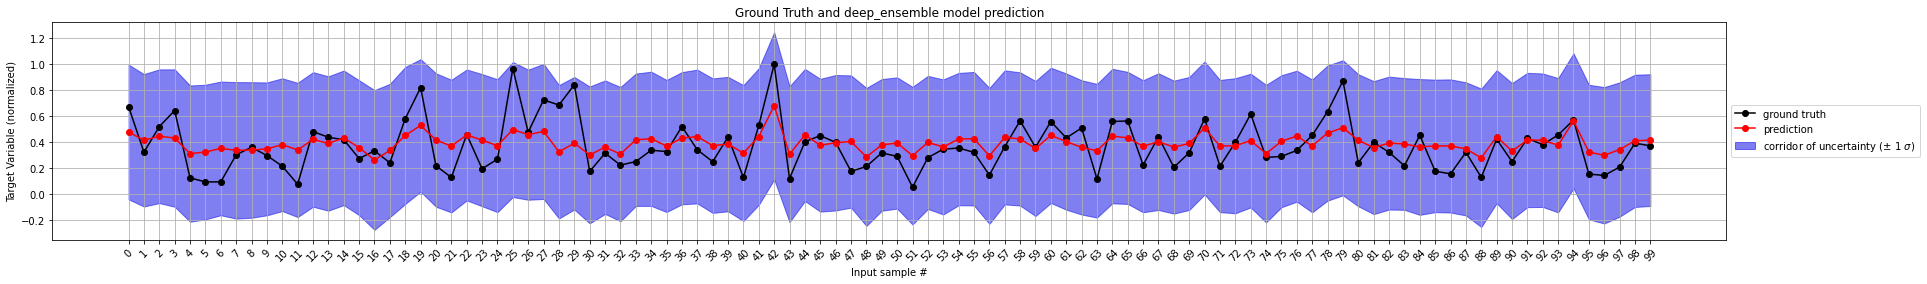

In [13]:
start_index = np.random.randint(test_data.shape[0]-150)
#print('start_index \n ', start_index)

#random = range(start_index, start_index+100)
random = range(0, 100)

#print('random \n ', random)

test_labels_plot= np.asarray([float(test_labels[i]) for i in random])
#print('test labels plot \n ', test_labels_plot)
mean_plot = np.asarray([float(pred_mean[i]) for i in random])
std_plot = np.asarray([float(pred_std[i]) for i in random])

#print('unique value of predicted standard deviation \n ', np.unique(std_plot))

plot_gt_vs_pred(test_labels_plot, mean_plot, std_plot, path+'output_plots/'+uncert_name+'_vs_prediction', random, uncert_name)

## Plot explanation function

In [14]:
# code for horizontal bar chart 

def plot_explanation(grads_plot, feature_names, sample_number=None, err=None, save_file_path=None, combination_title=None, coff=None):
    plt.figure(figsize=(8, 5))
    #plt.barh(pos, vals, color=colors) #this code works well but does not have legend or text in int

    print('grads_plot ', list(grads_plot))

    colors = ['C1' if x > 0 else 'C0' for x in list(grads_plot)] # originally negative=red and positive=green (coloring scheme)
    colors_set = set(colors)
    #print('colors_set before ', colors_set)
    colors_set = ['positive' if c == 'C1' else 'negative' for c in colors_set]
    #print('colors_set after ', colors_set)
    exp = list(grads_plot)
    pos = np.arange(len(exp)) + .5
    #print('pos values for plot are ', pos)

    vals = [float(x) for x in exp]
    vals_str = [str(round(val, 3)) for val in vals]
    #print('vals_str ', vals_str)

    #colors = ['r', 'g', 'b']
    labels = colors_set 
    legend_colors = list(set(colors))
    #print(legend_colors)
    handles = [plt.Rectangle((0,0),1,1, color=legend_colors[label]) for label in range(len(labels))]
    #print(handles)

    vals = [np.abs(num) if num  == 0 else num for num in vals] # removing the sign from 0 vals
    #print('vals ', vals)

    #max_horizontal_value_to_plot_text_box = np.max(vals)

    for i, v in enumerate(vals):
        if err is None:
            # in case the text box needs to be moved along the bar then switch 0 to v
            plt.text(v, i+0.5, str(round(v, 3)), Bbox = dict(facecolor = 'grey', alpha =0.2)) # https://www.geeksforgeeks.org/adding-value-labels-on-a-matplotlib-bar-chart/

        elif err is not None:
            # in case of the combined explanation, the text box should contain the mean+-std as well
            plt.text(v, i+0.7, str(round(v, 3))+'$\pm$'+str(round(err[i], 3)), Bbox = dict(facecolor = 'grey', alpha =0.2))

    axx = plt.barh([i for i in pos], vals, xerr=err, align='center', color=colors, alpha=0.75) # this code appropriate legend

    plt.grid(alpha=0.5)
    plt.ylabel('feature names')
    plt.xlabel('feature coefficient')
    plt.yticks(pos, feature_names[:-1])

    if err is not None:
        error = plt.plot([], label='uncertainty ($\pm \sigma$)', linewidth=3, linestyle='-', color='k')
        plt.title(f'combined explanation , prediction : {combination_title[0]} $\pm$ {combination_title[1]} , GT : {combination_title[2]}')
        main_bars = [plt.Rectangle((0,0),1,1, color=legend_colors[label]) for label in range(len(labels))]
        #first_legend = plt.legend(handles=error)
        #second_legend = plt.legend(handles=main_bar)

        handles = error + main_bars #https://stackoverflow.com/questions/28732845/combine-two-pyplot-patches-for-legend       
        error_label = ['uncertainty ($\pm \sigma$)']
        main_bars_label = colors_set

        labels = error_label + main_bars_label
        #plt.legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.5))
        plt.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=3)

    else:
        handles=[plt.Rectangle((0,0),1,1, color=legend_colors[label]) for label in range(len(labels))]
        plt.title(f'explanation for sample_number {sample_number}')
        #plt.legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.5)) # https://stackoverflow.com/questions/57340415/matplotlib-bar-plot-add-legend-from-categories-dataframe-column
        plt.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=3)

    if coff:
        plt.ylabel('feature name')
        plt.title(f'{sample_number}')
        plt.xlabel('coefficient of variation ($\sigma$+$\epsilon$)/($\mu$+$\epsilon$)')
    
    plt.subplots_adjust()
    #plt.savefig(save_file_path+'.pdf', bbox_inches='tight')
    #plt.savefig(save_file_path+'.png', bbox_inches='tight')

## Compute GBP explanation

In [15]:
# tf1 implementation for GBP 

import numpy as np

import keras
from keras import backend as K

import tensorflow as tf
from tensorflow.python.framework import ops

#Code partially based on :
# https://github.com/eclique/keras-gradcam/blob/master/grad_cam.py
# https://github.com/mvaldenegro/keras-snippets/blob/master/visualization/guided_bp.py
def make_guided_bp_model(model_fn):
    """
        Transform model to have overriden ReLU gradient for guided backpropagation.
        Parameters
        ----------
        model_fn: callable
            Function that builds and returns a model instance    
    """

    if "GuidedBackProp" not in ops._gradient_registry._registry:
        @ops.RegisterGradient("GuidedBackProp")
        def _GuidedBackProp(op, grad):
            dtype = op.inputs[0].dtype
            return grad * tf.cast(grad > 0., dtype) * \
                   tf.cast(op.inputs[0] > 0., dtype)

    g = K.get_session().graph
    with g.gradient_override_map({'Relu': 'GuidedBackProp'}):
        gbp_model = model_fn

    return gbp_model

def guided_bp(input_image, gbp_model, output_idx=-1):
    """
        Performs guided backpropagation saliency computation.
        Parameters
        ----------
        input_image: numpy array
            Image to compute saliency
        gbp_model: keras.models.Model
            Keras model with overriden gradient, see make_guided_bp_model
        layer_name: str
            Name of the layer to compute gradients
        output_idx: int
            Index of the output neuron to compute gradients, defaults to use whole output vector
    """
    print('gbp_model layers : ')
    for i in gbp_model.layers:
        print('layer name ', i.name) # -1 layer should correspond to the dense (var) and -2 should corresponc to the dense (mean)

    inp = gbp_model.input
    outp = gbp_model.layers[-2].output   # -1 correspondes to the dense (var) and -2 should correspond the dense (mean)
    
    if output_idx > 0:
        outp = outp[:, output_idx]

    gradient = K.gradients(outp, inp)[0]
    grad_fn = K.function([inp, K.learning_phase()], [gradient])
    grads_val = grad_fn([input_image, 0])[0]

    output_fn = K.function([inp], [outp])
    output = output_fn([input_image])

    #print('ensemble output is ', output)
    #print('prediction shape ', output[0].shape)

    return grads_val, output

In [16]:
# Analysis of the input 
#test_sample_index=np.random.randint(3000)
#print('index ', test_sample_index)
#test_input_temp = test_data[test_sample_index]
#ground_truth = test_labels[test_sample_index]
#test_input = np.expand_dims(test_input_temp, axis=0)
#print('test_input :', test_input)
#print('ground_truth : ', ground_truth)
#print('feature_name : ', feature_names)

1
input to be explained 
  [[0.60681115 0.18162393 0.82352941 0.04940218 0.05685804 0.06739313
  0.05580357 0.21372809]]
ground truth 
  [0.32251241]
gbp_model layers : 
layer name  input_1
layer name  dense
layer name  dense_1
layer name  dense_2
layer name  mean
layer name  var
grads_plot  [0.09978506, 0.10515411, 0.05695335, -0.024443474, -0.027580038, -0.06487617, 0.07877932, -0.021259073]
-------------------------------
gbp_model layers : 
layer name  input_2
layer name  dense_3
layer name  dense_4
layer name  dense_5
layer name  mean
layer name  var
grads_plot  [-0.15171075, 0.095966354, 0.27913857, -0.31589723, 0.29759896, 0.17924239, 0.15088603, 0.6301955]
-------------------------------
gbp_model layers : 
layer name  input_3
layer name  dense_6
layer name  dense_7
layer name  dense_8
layer name  mean
layer name  var
grads_plot  [-0.0008148104, 0.07720154, 0.13178565, -0.06119243, -0.1881722, -0.004044667, 0.36083025, 0.056300573]
-------------------------------
gbp_model laye

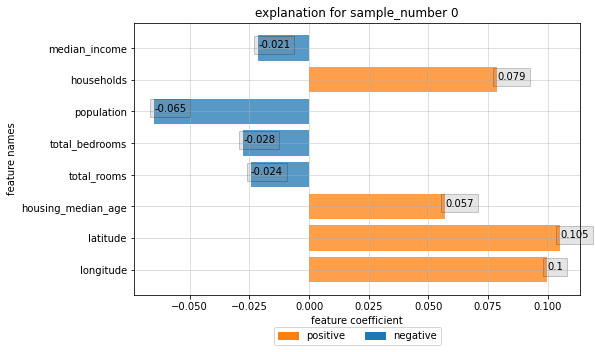

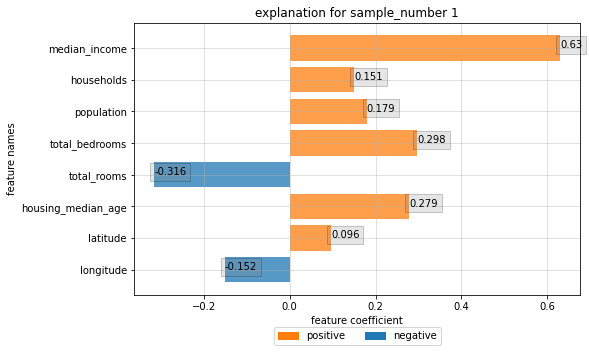

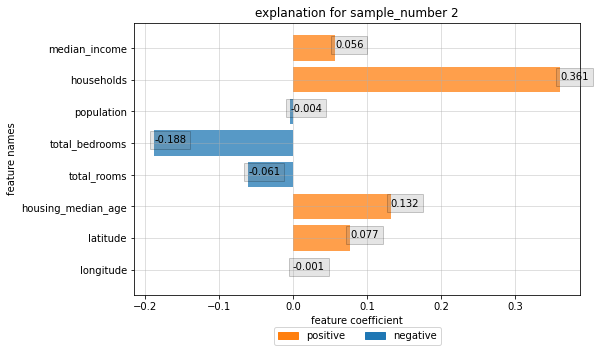

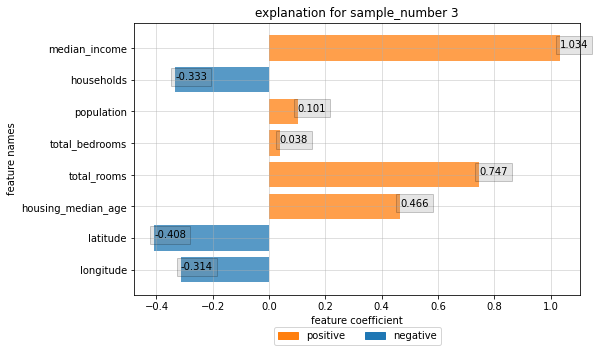

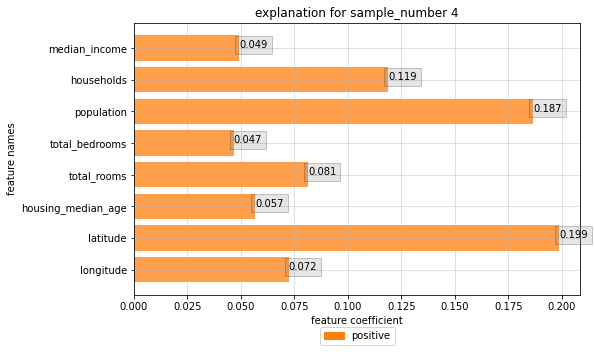

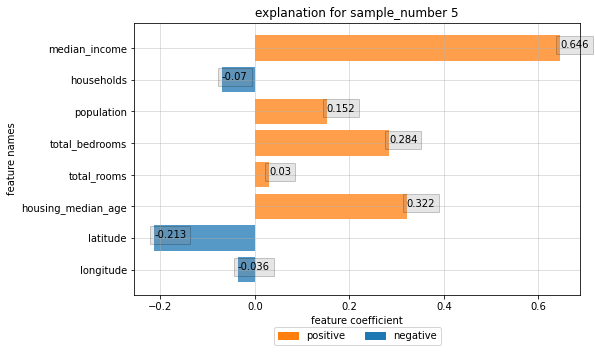

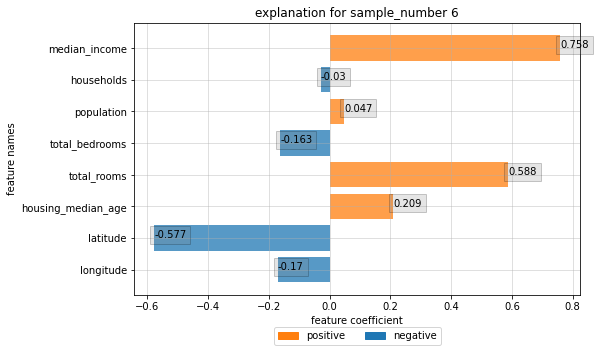

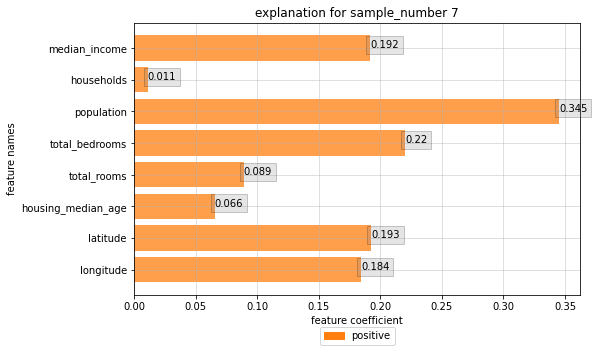

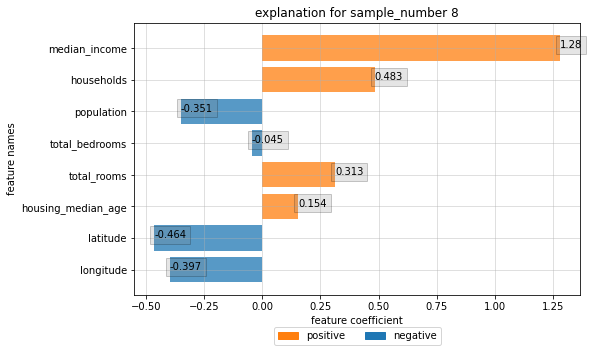

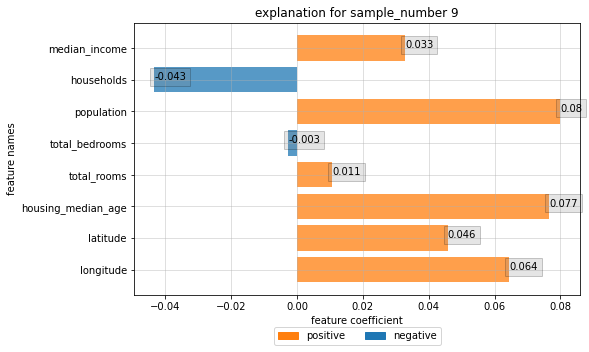

In [17]:
list_of_gbp_exp = [] 
list_of_component_output = [] 

for test_sample_index in range(1, 10):
    print(test_sample_index)
    gbp_exp = [] 
    component_output = [] 

    num_estimators = len(model) 

    test_input = np.expand_dims(test_data[test_sample_index, :], axis=0)
    print('input to be explained \n ', test_input)
    print('ground truth \n ', test_labels[test_sample_index, : ])
    for i in range(num_estimators):
        gb_model = make_guided_bp_model(model[i])   # pick individual ensemble component from the list of loaded models and convert that model to gbp model
        sample_exp, sample_outp = guided_bp(test_input, gb_model)  # produce the sample explanation and the sample output using this gbp model 
        gbp_exp.append(sample_exp)
        component_output.append(sample_outp)
        plot_explanation(sample_exp.squeeze(axis=0),  # pass explanation obtained in the previous steps as list 
                        feature_names, 
                        sample_number=i, 
                        err=None, 
                        #save_file_path=path+'output_plots/explanation_for_component_number_'+str(i)+'_input_id_'+str(test_sample_index)+'_'+difficulty,
                        save_file_path=None, 
                        combination_title=None)
        print('-------------------------------')

    list_of_gbp_exp.append(gbp_exp)
    list_of_component_output.append(component_output)
    print('xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx')
    break

[0.32251241]
mean_of_predictions 
  0.414
std_of_prediction 
  0.048
gt 
  0.323
mixture_mean is  [[0.41407552]]
mixture_var is  [[0.26102155]]
mean  [[0.41407552]]
std  [[0.5109027]]
std  0.511
grads_plot  [-0.06498244, -0.09471695, 0.18181589, 0.14582127, 0.046037827, 0.06716437, 0.07280545, 0.4657895]
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx


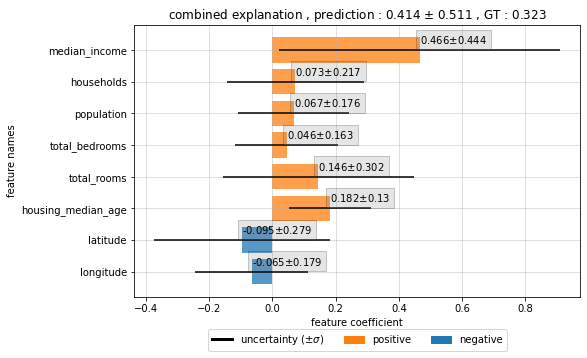

In [18]:
list_of_mean_of_feature_exp = [] 
list_of_std_of_feature_exp = [] 

list_of_mean_of_predictions = [] 
list_of_std_of_predictions = [] 

for i in range(len(list_of_gbp_exp)):  
    
    gbp_exp_arr_temp = np.array(list_of_gbp_exp[i])
    gbp_exp_arr = np.reshape(gbp_exp_arr_temp, (-1, 8))
    #print(gbp_exp_arr.shape)

    #print('gbp exp \n ', list_of_gbp_exp[i])
    # appending mean annnd std of the feature explanation for an individual input
    mean_of_feature_exp = np.mean(gbp_exp_arr, axis=0)
    list_of_mean_of_feature_exp.append(mean_of_feature_exp)

    std_of_feature_exp = np.std(gbp_exp_arr, axis=0) 
    list_of_std_of_feature_exp.append(std_of_feature_exp)

    #print('mean exp \n ', mean_of_feature_exp)
    #print('std exp \n ', std_of_feature_exp)

    #print('feature names :\n  ', feature_names)
    component_output_arr_temp = np.array(list_of_component_output[i])
    component_output_arr = np.reshape(component_output_arr_temp, (-1, 1))

    #print('component_output \n', list_of_component_output[i])
    #print('component_output shape : \n', len(list_of_component_output[i]))

    # appending the mean and std of the prediction for an individual input 
    mean_of_predictions = np.mean(component_output_arr, axis=0)
    list_of_mean_of_predictions.append(mean_of_predictions)

    std_of_predictions = np.std(component_output_arr, axis=0)
    list_of_std_of_predictions.append(std_of_predictions) 


    mean_of_predictions = str(round(float(mean_of_predictions), 3))
    std_of_predictions = str(round(float(std_of_predictions), 3))
    v = test_labels[test_sample_index, : ]
    print(v)
    ground_truth = str(round(v[0], 3))

    print('mean_of_predictions \n ', mean_of_predictions)
    print('std_of_prediction \n ', std_of_predictions)
    print('gt \n ', ground_truth)
    mean, std = stochastic_model.predict_output(test_input)
    print('mean ', mean)
    print('std ', std)
    std = str(round(std[0][0], 3))
    print('std ', std)
    plot_explanation(mean_of_feature_exp,  # pass explanation as list 
                    feature_names, 
                    sample_number=i, 
                    err=std_of_feature_exp, 
                    #save_file_path=path+'output_plots/combined_explanation_of_'+str(component_output_arr.shape[0])+'_samples_for_input_id_'+str(index_of_most_extreme_inputs_to_predict[i])+'_'+difficulty,
                    save_file_path=None, 
                    combination_title=[mean_of_predictions, std, ground_truth])
    print('xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx')

## Coefficient of Variation

coefficient_of_variation  [-2.816138121615728, -2.9830116873157624, 0.7183488472366368, 2.060434649376562, 3.481435401434862, 2.5998531222674948, 2.9591678308998235, 0.9535208023414767]
grads_plot  [-2.816138121615728, -2.9830116873157624, 0.7183488472366368, 2.060434649376562, 3.481435401434862, 2.5998531222674948, 2.9591678308998235, 0.9535208023414767]


<Figure size 576x360 with 0 Axes>

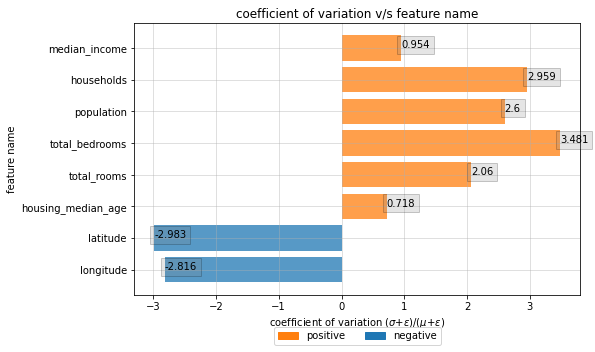

In [19]:
eps=0.001
# compute coefficient of variation 
coefficient_of_variation = [(i+eps)/(j+eps) for i,j in zip(std_of_feature_exp, mean_of_feature_exp)]
print('coefficient_of_variation ', coefficient_of_variation)

plt.figure(figsize=(8, 5))
colors = ['C1' if x > 0 else 'C0' for x in list(coefficient_of_variation)] # originally negative=red and positive=green (coloring scheme)
colors_set = set(colors)
legend_colors = list(set(colors))
colors_set = ['positive' if c == 'C1' else 'negative' for c in colors_set]

bars = [plt.Rectangle((0,0),1,1, color=legend_colors[label]) for label in range(len(colors_set))]
#uncomment the next 2 line in case cv threshold is needed 
#thresh = plt.plot([], label='threshold', linewidth=3, linestyle='-', color='k')
#handles = bars + thresh

main_bars_label = colors_set

# uncomment following two lines in case cv threshold is needed
#error_label = ['threshold']
#labels = main_bars_label + error_label 

# uncomment following two lines to remove threshold
handles = bars 
labels = main_bars_label


'''
plt.bar(feature_names[:-1], coefficient_of_variation, color=colors, alpha=0.75)

# uncomment the following 2 lines to get the threshold lines
#plt.plot(feature_names[:-1], [30]*len(feature_names[:-1]), '--k')
#plt.plot(feature_names[:-1], [-30]*len(feature_names[:-1]), '--k')
plt.xticks(rotation=90)
plt.xlabel('feature name')
plt.ylabel(r'coefficient of variation : ($\sigma$ + $\epsilon$)/ ($\mu$ + $\epsilon$ )')
plt.grid(alpha=0.5) 


plt.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, -0.475), ncol=2)
plt.title('feature name v/s coefficient of variation')

for i, v in enumerate(coefficient_of_variation):
    # in case the text box needs to be moved along the bar then switch 0 to v
    plt.text(i-0.2, v, str(round(v, 3)), Bbox = dict(facecolor = 'grey', alpha =0.2)) # https://www.geeksforgeeks.org/adding-value-labels-on-a-matplotlib-bar-chart/
'''
plot_explanation(coefficient_of_variation, 
                     feature_names, 
                     sample_number="coefficient of variation v/s feature name", 
                     #save_file_path=explanation_heatmap_path+'/input_id_'+str(idx-1)+'_combined_exp',
                     save_file_path=None,
                    combination_title='coefficient of variation',
                     coff=True)

In [20]:
# coefficient of variation / relative standard deviation (RSD) (sigma divided by mu) 
# https://link.springer.com/chapter/10.1007/978-3-642-80328-4_13 [source that 30% cv could act as a threshold]
# https://en.wikipedia.org/wiki/Coefficient_of_variation
# https://www.formpl.us/blog/coefficient-variation

'''
for input_id in range(len(list_of_gbp_exp)):
    print('mean_feature_weight ', list_of_mean_of_feature_exp[input_id])
    print('std_feature_weight ', list_of_std_of_feature_exp[input_id])
    print('feature_names ', feature_names)

    eps=1e-3
    # compute coefficient of variation 
    
    coefficient_of_variation = [100*(i/(j+eps)) if -0.001<j<0.001 else 100*(i/j) for i,j in zip(list_of_std_of_feature_exp[input_id], list_of_mean_of_feature_exp[input_id])]
    print('coefficient_of_variation ', coefficient_of_variation)

    plt.figure(figsize=(8, 5))
    colors = ['C1' if x > 0 else 'C0' for x in list(coefficient_of_variation)] # originally negative=red and positive=green (coloring scheme)
    colors_set = set(colors)
    legend_colors = list(set(colors))
    colors_set = ['positive' if c == 'C1' else 'negative' for c in colors_set]

    bars = [plt.Rectangle((0,0),1,1, color=legend_colors[label]) for label in range(len(colors_set))]
    #uncomment the next 2 line in case cv threshold is needed 
    #thresh = plt.plot([], label='threshold', linewidth=3, linestyle='-', color='k')
    #handles = bars + thresh

    main_bars_label = colors_set

    # uncomment following two lines in case cv threshold is needed
    #error_label = ['threshold']
    #labels = main_bars_label + error_label 

    # uncomment following two lines to remove threshold
    handles = bars 
    labels = main_bars_label

    plt.bar(feature_names[:-1], coefficient_of_variation, color=colors)
    # uncomment the following 2 lines to get the threshold lines
    #plt.plot(feature_names[:-1], [30]*len(feature_names[:-1]), '--k')
    #plt.plot(feature_names[:-1], [-30]*len(feature_names[:-1]), '--k')
    plt.xticks(rotation=90)
    plt.xlabel('feature name')
    plt.ylabel(r'coefficient of variation : 100 $\times$ ($\sigma$ / $\mu$ )%')
    plt.grid(alpha=0.2) 


    plt.legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title('feature name v/s coefficient of variation')

    for i, v in enumerate(coefficient_of_variation):
        # in case the text box needs to be moved along the bar then switch 0 to v
        plt.text(i-0.2, v, str(round(v, 3)), Bbox = dict(facecolor = 'grey', alpha =0.2)) # https://www.geeksforgeeks.org/adding-value-labels-on-a-matplotlib-bar-chart/

    #plt.savefig(path+'output_plots/feature_name_vs_coefficient_of_variation_'+
    #            str(index_of_most_extreme_inputs_to_predict[input_id])+'_'+difficulty+'.pdf', bbox_inches='tight')
    #plt.savefig(path+'output_plots/feature_name_vs_coefficient_of_variation_'+
    #            str(index_of_most_extreme_inputs_to_predict[input_id])+'_'+difficulty+'.png', bbox_inches='tight')

    #https://en.wikipedia.org/wiki/Kurtosis
'''

"\nfor input_id in range(len(list_of_gbp_exp)):\n    print('mean_feature_weight ', list_of_mean_of_feature_exp[input_id])\n    print('std_feature_weight ', list_of_std_of_feature_exp[input_id])\n    print('feature_names ', feature_names)\n\n    eps=1e-3\n    # compute coefficient of variation \n    \n    coefficient_of_variation = [100*(i/(j+eps)) if -0.001<j<0.001 else 100*(i/j) for i,j in zip(list_of_std_of_feature_exp[input_id], list_of_mean_of_feature_exp[input_id])]\n    print('coefficient_of_variation ', coefficient_of_variation)\n\n    plt.figure(figsize=(8, 5))\n    colors = ['C1' if x > 0 else 'C0' for x in list(coefficient_of_variation)] # originally negative=red and positive=green (coloring scheme)\n    colors_set = set(colors)\n    legend_colors = list(set(colors))\n    colors_set = ['positive' if c == 'C1' else 'negative' for c in colors_set]\n\n    bars = [plt.Rectangle((0,0),1,1, color=legend_colors[label]) for label in range(len(colors_set))]\n    #uncomment the next 2 

## Saving the explanations (np arrays) for later analysis

In [21]:
#np.savetxt(path+'/list_of_std_of_predictions', list_of_std_of_predictions, newline=' ')
#np.savetxt(path+'/sorted_mse_test_set', sorted_mse_test_set, newline=' ')
#np.savetxt(path+'/index_of_most_extreme_inputs_to_predict', index_of_most_extreme_inputs_to_predict, newline=' ')

## Analysis

### Prediction mse vs prediction std for the extreme examples

[0.04798863] 0.3167310635022077


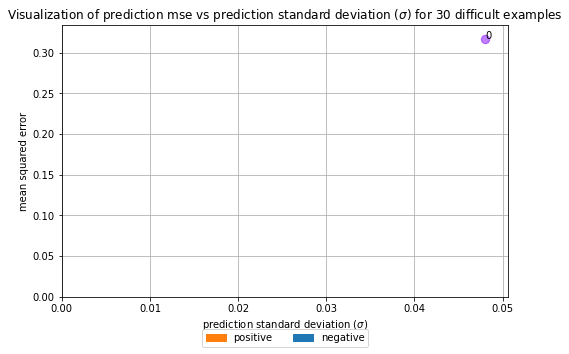

In [22]:
def evaluation_plot(number_of_most_extreme_inputs_to_be_analysed, quantity_a, quantity_b, index_of_most_extreme_inputs_to_predict, x_label, y_label, title, difficulty_flag, filename):
    i = 0 
    plt.figure(figsize=(8, 5))

    #https://stackoverflow.com/questions/68209351/how-to-make-a-color-map-with-many-unique-colors-in-seaborn
    


    colors = cm.rainbow(np.linspace(0, 1, number_of_most_extreme_inputs_to_be_analysed+1))

    if difficulty_flag == 'difficult':
        # selecting those mse values corresponding to the difficulty level 
        quantity_b = quantity_b[-number_of_most_extreme_inputs_to_be_analysed:]
        for x, y, c in zip(quantity_a, quantity_b, colors):
            print(x, y)
            plt.scatter(x, y, color=c, s=70, alpha=0.5, label=f'input_id #{index_of_most_extreme_inputs_to_predict[i]} : {i}')
            plt.text(x[0], y, str(i))
            i+=1

    elif difficulty_flag == 'easy':
        quantity_b = quantity_b[:number_of_most_extreme_inputs_to_be_analysed]
        for x, y, c in zip(quantity_a, quantity_b, colors):
            print(x, y)
            plt.scatter(x, y, color=c, s=70, alpha=0.5, label=f'input_id #{index_of_most_extreme_inputs_to_predict[i]} : {i}')
            plt.text(x[0], y, str(i))
            #plt.annotate(f'{index_of_most_extreme_inputs_to_predict[i]}', (float(y)+0.1, float(x)+0.1))
            i+=1  

    plt.grid()
    #plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=3)
    
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    #plt.tight_layout()
    plt.title(title)
    #https://stackoverflow.com/questions/11744990/how-to-set-auto-for-upper-limit-but-keep-a-fixed-lower-limit-with-matplotlib
    plt.gca().set_ylim(bottom=0)
    plt.gca().set_xlim(left=0)


    ##plt.savefig(filename+'.pdf', bbox_inches='tight')
    #plt.savefig(filename+'.png', bbox_inches='tight')
    plt.show()

evaluation_plot(number_of_most_extreme_inputs_to_be_analysed,
                list_of_std_of_predictions,
                sorted_mse_test_set,
                index_of_most_extreme_inputs_to_predict,
                'prediction standard deviation ($\sigma$)',
                'mean squared error',
                f'Visualization of prediction mse vs prediction standard deviation ($\sigma$) for {number_of_most_extreme_inputs_to_be_analysed} {difficulty} examples',
                difficulty,
                path+'output_plots/prediction_mse_vs_prediction_std_for_'+str(number_of_most_extreme_inputs_to_be_analysed)+'_'+str(difficulty)+'_examples')

### Prediction mse vs explanation feature std summation for extreme examples

matrix of std of feature exp 
 [[0.17918338 0.27855876 0.13032559 0.30151564 0.16275916 0.17621735
  0.21740271 0.4440935 ]]
shape of matix of std of feature exp  (1, 8)
shape of sum of individual std of feature exp  (1,)
sum_of_individual_std_of_feature_exp 
  [[1.8900561]]
sorted_mse_test_set[-number_of_most_extreme_inputs_to_be_analysed:] 
  [0.3167310635022077, 0.3179347378164755, 0.3203732558509814, 0.32281377490093977, 0.3236039989013796, 0.32708612031279916, 0.32789138269640705, 0.3296345292948012, 0.33279573572377774, 0.33841787200577583, 0.34050538208271874, 0.3484714967865727, 0.3490875174378672, 0.3659558977677556, 0.37161318656595543, 0.3778615363886252, 0.3778703298571918, 0.38069188117847047, 0.3962231269705903, 0.40112933431235903, 0.40245286082881987, 0.403703010306433, 0.4066099293852153, 0.40823721026115206, 0.4082712956692525, 0.42157877529200843, 0.4352460889196782, 0.4437144496730157, 0.4584411272988838, 0.5234477844371667]
[1.8900561] 0.3167310635022077


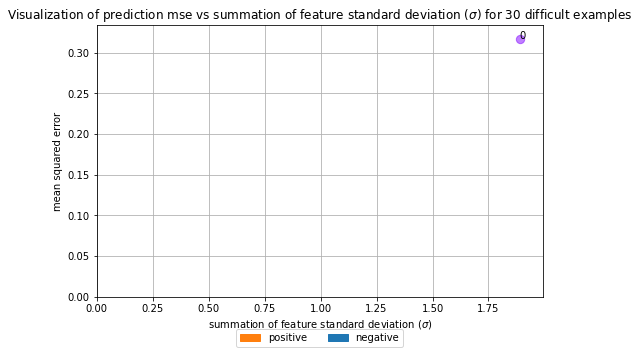

In [23]:
matrix_of_std_of_feature_exp = np.array(list_of_std_of_feature_exp)
print('matrix of std of feature exp \n', matrix_of_std_of_feature_exp)
print('shape of matix of std of feature exp ', matrix_of_std_of_feature_exp.shape)
sum_of_individual_std_of_feature_exp = np.sum(matrix_of_std_of_feature_exp, axis=1)
print('shape of sum of individual std of feature exp ', sum_of_individual_std_of_feature_exp.shape)

sum_of_individual_std_of_feature_exp = [[i] for i in sum_of_individual_std_of_feature_exp]

print('sum_of_individual_std_of_feature_exp \n ', sum_of_individual_std_of_feature_exp)
print('sorted_mse_test_set[-number_of_most_extreme_inputs_to_be_analysed:] \n ', sorted_mse_test_set[-number_of_most_extreme_inputs_to_be_analysed:])

evaluation_plot(number_of_most_extreme_inputs_to_be_analysed,
                sum_of_individual_std_of_feature_exp,
                sorted_mse_test_set,
                index_of_most_extreme_inputs_to_predict,
                'summation of feature standard deviation ($\sigma$)',
                'mean squared error',
                f'Visualization of prediction mse vs summation of feature standard deviation ($\sigma$) for {number_of_most_extreme_inputs_to_be_analysed} {difficulty} examples',
                difficulty,
                path+'output_plots/prediction_mse_vs_summation_of_feature_std_for_'+str(number_of_most_extreme_inputs_to_be_analysed)+'_'+str(difficulty)+'_examples')

### Explanation feature standard deviation summation vs prediction standard deviation for extreme examples

[1.8900561] [0.04798863]


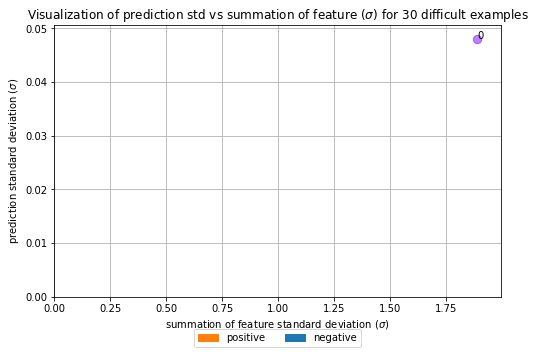

In [24]:
evaluation_plot(number_of_most_extreme_inputs_to_be_analysed,
                sum_of_individual_std_of_feature_exp,
                list_of_std_of_predictions,
                index_of_most_extreme_inputs_to_predict,
                'summation of feature standard deviation ($\sigma$)',
                'prediction standard deviation ($\sigma$)',
                f'Visualization of prediction std vs summation of feature ($\sigma$) for {number_of_most_extreme_inputs_to_be_analysed} {difficulty} examples',
                difficulty,
                path+'output_plots/summation_of_feature_std_vs_prediction_std_for_'+str(number_of_most_extreme_inputs_to_be_analysed)+'_'+str(difficulty)+'_examples')

## Zip and download the output plots folder 

In [25]:
#if difficulty == 'easy':
#    !zip -r '/content/output_plots_easy.zip' '/content/drive/MyDrive/MasterThesis/CaliforniaHousingDatasetTests/GBP_explanation/deep_ensemble/output_plots/'

#    from google.colab import files
#    files.download('/content/output_plots_easy.zip')

#elif difficulty == 'difficult':
#    !zip -r '/content/output_plots_difficult.zip' '/content/drive/MyDrive/MasterThesis/CaliforniaHousingDatasetTests/GBP_explanation/deep_ensemble/output_plots/'

#    from google.colab import files
#    files.download('/content/output_plots_difficult.zip')
